In [9]:
# Import packages 
import corticalmapping.core.FileTools as ft
import corticalmapping.core.TimingAnalysis as ta
import corticalmapping.HighLevel as hl 
import corticalmapping.RetinotopicMapping as rm
import corticalmapping.core.PlottingTools as pt
import corticalmapping.core.ImageAnalysis as ia 
from toolbox.misc import BinarySlicer
from timing import SpatiotemporalTuningTrial as sm

# Import dependencies
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os 
import tifffile as tiff
import seaborn as sns
import pandas as pd
from scipy.signal import butter, lfilter, bessel, ellip, firwin, filtfilt, get_window
import tables as tb
from scipy import ndimage
from scipy import misc 
import cv2

sns.set(style = "ticks",palette = "muted", color_codes = True)

%matplotlib inline

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import pprint
import allensdk.brain_observatory.stimulus_info as stim_info
from allensdk.brain_observatory.drifting_gratings import DriftingGratings

# get cux2 experiments in V1 
manifest_file_path = r"\\allen\programs\braintv\workgroups\nc-ophys\ObservatoryPlatformPaperAnalysis\platform_boc_pre_2018_3_16\manifest.json"
ophys_experiment_path = r"\\allen\programs\braintv\workgroups\nc-ophys\ObservatoryPlatformPaperAnalysis\platform_boc_pre_2018_3_16\ophys_experiment_data"
boc = BrainObservatoryCache(manifest_file= manifest_file_path)
cux2_ecs = boc.get_experiment_containers(cre_lines=['Cux2-CreERT2'])


cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)
cux2_ec_ids = [ ec['id'] for ec in cux2_ecs ]
cux2_cells = cells[cells['experiment_container_id'].isin(cux2_ec_ids)]


cell_exp = boc.get_ophys_experiments(cell_specimen_ids=cux2_cells['cell_specimen_id'].values,
                                     stimuli=[stim_info.DRIFTING_GRATINGS])


In [ ]:
rel_vs_resp_all = pd.DataFrame(columns = ['cell_specimen_id',
                                          'area',
                                          'reliability',
                                          'reliability_marshel',
                                          'reliability_corr',
                                          'DSI',
                                          'OSI',
                                          'TF',
                                          'pref_ori',
                                          'peak dF/F', 
                                          'Tohmi', 
                                          'Marshel',
                                          'Andermann', 
                                          'Roth', 
                                          'Sun'])
for exp in cell_exp:     
    print("Experiment with drifting gratings:")
    pprint.pprint(exp)
    rel_vs_resp = pd.DataFrame(columns = ['cell_specimen_id',
                                          'area',
                                          'reliability',
                                          'reliability_marshel',
                                          'reliability_corr',
                                          'DSI',
                                          'OSI',
                                          'TF',
                                          'pref_ori',
                                          'peak dF/F', 
                                          'Tohmi', 
                                          'Marshel',
                                          'Andermann', 
                                          'Roth', 
                                          'Sun'])    
    #file_name = os.path.join(ophys_experiment_path, str(exp['id']))
    data_set = boc.get_ophys_experiment_data(exp['id'])
    dg = DriftingGratings(data_set)
    stim_table = dg.stim_table

    print rel_vs_resp.head()
    # create dataframe with reliability, peak dF/F, and whether they passed each criterion
    
    rel_vs_resp['DSI'] = dg.peak.dsi_dg
    rel_vs_resp['pref_ori'] = dg.peak.ori_dg
    rel_vs_resp['OSI'] = dg.peak.osi_dg
    rel_vs_resp['TF'] = dg.peak.tf_dg
    rel_vs_resp['reliability'] = dg.peak.reliability_dg
    rel_vs_resp['peak dF/F'] = dg.peak.peak_dff_dg
    rel_vs_resp['Sun'] = rel_vs_resp['peak dF/F']> 10
    rel_vs_resp['cell_specimen_id'] = exp['id']
    rel_vs_resp['area'] = exp['targeted_structure']
    for cell in range(dg.numbercells):
        # Andermann
        pref_tf = dg.tfvals[dg.peak.tf_dg.iloc[cell]]
        pref_ori = dg.orivals[dg.peak.ori_dg.iloc[cell]]
        resp_tf = dg.mean_sweep_response[(stim_table['temporal_frequency']== pref_tf) & (stim_table['orientation']== pref_ori)][str(cell)].values
        resp_blank = dg.mean_sweep_response[stim_table['blank_sweep']==True][str(cell)].values
        t2, p2 = sc.stats.ttest_ind(resp_tf,resp_blank)
        rel_vs_resp['p_blank'] = p2
        rel_vs_resp['Andermann'].iloc[cell] = p2 < 0.05/40
        
        # Marshel 
        stdev_tf = sc.std(resp_tf)
        mean_tf = np.mean(resp_tf)
        stdev_blank = sc.std(resp_blank)
        mean_blank = np.mean(resp_blank)
        reliability = (mean_tf- mean_blank) / (stdev_tf + stdev_blank)
        rel_vs_resp['Marshel'].iloc[cell] = (reliability > 1) & (mean_tf > 6)
        rel_vs_resp['reliability_marshel'].iloc[cell] = reliability
        
        #Roth
        resp_baseline = dg.sweep_response[str(cell)].apply(lambda x : x[:30])
        resp = dg.sweep_response[str(cell)].apply(lambda x : x[30:90])
        resp_baseline_mean  = resp_baseline.apply(np.mean)[(stim_table['temporal_frequency']== pref_tf) & (stim_table['orientation']== pref_ori)]
        resp_baseline_std = resp_baseline.apply(np.std)[(stim_table['temporal_frequency']== pref_tf) & (stim_table['orientation']== pref_ori)]
        resp_mean = resp.apply(np.mean)[(stim_table['temporal_frequency']== pref_tf) & (stim_table['orientation']== pref_ori)]
        rel_vs_resp['Roth'].iloc[cell] = np.sum((resp_mean > (resp_baseline_mean + resp_baseline_std*3)) & (resp_mean > 5))/np.float(resp_baseline_mean.shape[0])>0.5
        rel_vs_resp['reliability_percentage'] = np.sum(resp_mean > (resp_baseline_mean + resp_baseline_std*3))/np.float(resp_baseline_mean.shape[0])
        
        # Tohmi 
        sweep_resp_pref = dg.sweep_response[(stim_table.orientation==pref_ori) & (stim_table.temporal_frequency==pref_tf)][str(cell)]
        mean_sweep_resp_pref = sweep_resp_pref.mean()
        max_resp = mean_sweep_resp_pref[30:90].max()
        rel_vs_resp['Tohmi'].iloc[cell] = max_resp > 4
        
        # Reliability corr 
        rel_vs_resp['reliability_corr'].iloc[cell] = np.mean(np.corrcoef(np.array([a for a in sweep_resp_pref]))[np.triu_indices(sweep_resp_pref.shape[0],k=1)])
       #rel_vs_resp['reliability_percentage'].iloc[cell] = 
        
    rel_vs_resp_all = rel_vs_resp_all.append(rel_vs_resp)
    del rel_vs_resp



Experiment with drifting gratings:
{'acquisition_age_days': 114,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'222420',
 'experiment_container_id': 511510664,
 'fail_eye_tracking': False,
 'id': 502199136,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222420',
 'targeted_structure': u'VISal'}
Empty DataFrame
Columns: [cell_specimen_id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


In [90]:
resp_baseline_mean

NameError: name 'resp_baseline_mean' is not defined

In [116]:
n = 0
reliability_percentage_all = pd.DataFrame( 
                                      columns = ['reliability_percentage'])
for exp in cell_exp:
    print exp
    data_set = boc.get_ophys_experiment_data(exp['id'])
    dg = DriftingGratings(data_set)
    stim_table = dg.stim_table
    ncells = dg.numbercells
    reliability_percentage = pd.DataFrame(index = np.arange(dg.numbercells), columns = ['reliability_percentage'])
    rel_vs_resp_all['area'][n:n+ncells] = exp['targeted_structure']
    
    n+=ncells
    for cell in range(dg.numbercells): 
        pref_tf = dg.tfvals[dg.peak.tf_dg.iloc[cell]]
        pref_ori = dg.orivals[dg.peak.ori_dg.iloc[cell]]
        resp_baseline = dg.sweep_response[str(cell)].apply(lambda x : x[:30])
        resp = dg.sweep_response[str(cell)].apply(lambda x : x[30:90])
        resp_mean = resp.apply(np.mean)[(stim_table['temporal_frequency']== pref_tf) & (stim_table['orientation']== pref_ori)]
        resp_baseline_mean  = resp_baseline.apply(np.mean)[(stim_table['temporal_frequency']== pref_tf) & (stim_table['orientation']== pref_ori)]
        resp_baseline_std = resp_baseline.apply(np.std)[(stim_table['temporal_frequency']== pref_tf) & (stim_table['orientation']== pref_ori)]
        #resp_mean = resp.apply(np.mean)[(stim_table['temporal_frequency']== pref_tf) & (stim_table['orientation']== pref_ori)]
        #rel_vs_resp['Roth'].iloc[cell] = np.sum((resp_mean > (resp_baseline_mean + resp_baseline_std*3)) & (resp_mean > 5))/np.float(resp_baseline_mean.shape[0])>0.5
        reliability_percentage['reliability_percentage'].iloc[cell]= np.sum(resp_mean > (resp_baseline_mean + resp_baseline_std*3))/np.float(resp_baseline_mean.shape[0])
        
    reliability_percentage_all = reliability_percentage_all.append(reliability_percentage)

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'222420', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 502199136, 'acquisition_age_days': 114, 'experiment_container_id': 511510664, 'targeted_structure': u'VISal', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222420'}
{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'222425', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 503412730, 'acquisition_age_days': 122, 'experiment_container_id': 511510695, 'targeted_structure': u'VISal', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222425'}
{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'222426', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 501876401, 'acquisition_age_days': 109, 'experiment_container_id': 511510715, 'targeted_structure': u'VISal', 'fail_eye_tracking': Tr

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'222424', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 504115289, 'acquisition_age_days': 124, 'experiment_container_id': 511510817, 'targeted_structure': u'VISpm', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222424'}
{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'225036', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 502376461, 'acquisition_age_days': 95, 'experiment_container_id': 511510753, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225036'}
{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'225037', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 503324629, 'acquisition_age_days': 102, 'experiment_container_id': 511510822, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'282820', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 566674372, 'acquisition_age_days': 117, 'experiment_container_id': 566674370, 'targeted_structure': u'VISl', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-282820'}
{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'222420', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 501574836, 'acquisition_age_days': 103, 'experiment_container_id': 511510667, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222420'}
{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'222425', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 501484643, 'acquisition_age_days': 102, 'experiment_container_id': 511510927, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 

In [281]:
n = 0
for exp in cell_exp:
    print exp
    data_set = boc.get_ophys_experiment_data(exp['id'])
    dg = DriftingGratings(data_set)
    stim_table = dg.stim_table
    ncells = dg.numbercells
    #reliability_percentage = pd.DataFrame(index = np.arange(dg.numbercells), columns = ['reliability_percentage'])
    rel_vs_resp_all['area'][n:n+ncells] = exp['targeted_structure']
    
    n+=ncells

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'222420', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 502199136, 'acquisition_age_days': 114, 'experiment_container_id': 511510664, 'targeted_structure': u'VISal', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222420'}


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'222425', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 503412730, 'acquisition_age_days': 122, 'experiment_container_id': 511510695, 'targeted_structure': u'VISal', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222425'}
{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'222426', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 501876401, 'acquisition_age_days': 109, 'experiment_container_id': 511510715, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222426'}
{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'225036', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 501933264, 'acquisition_age_days': 90, 'experiment_container_id': 511510797, 'targeted_structure': u'VISal', 'fail_eye_tracking': True

{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'225036', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 502376461, 'acquisition_age_days': 95, 'experiment_container_id': 511510753, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225036'}
{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'225037', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 503324629, 'acquisition_age_days': 102, 'experiment_container_id': 511510822, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225037'}
{'session_type': u'three_session_A', 'imaging_depth': 175, 'donor_name': u'225039', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 502666254, 'acquisition_age_days': 96, 'experiment_container_id': 511510645, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'222420', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 501574836, 'acquisition_age_days': 103, 'experiment_container_id': 511510667, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222420'}
{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'222425', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 501484643, 'acquisition_age_days': 102, 'experiment_container_id': 511510927, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222425'}
{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'225036', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 503109347, 'acquisition_age_days': 101, 'experiment_container_id': 511510779, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, '

In [282]:
rel_vs_resp_all.to_csv('ReliabilityVsResponsivenessDataAllAreas.csv')

In [175]:
rel_vs_resp_all = pd.DataFrame.from_csv('ReliabilityVsResponsivenessDataAreas.csv')

In [297]:
rel_vs_resp_all['reliability_percentage'] = reliability_percentage_all.values

In [336]:
# plot number of cells for each 
colors = ['r', 'b', 'g','m', 'c']
criteria = ['Tohmi', 'Andermann','Sun', 'Roth', 'Marshel']
features =  [ 'reliability',
              'reliability_marshel',
              'reliability_corr',
              'DSI',
              'OSI',
              'TF',
              'pref_ori',
              'peak dF/F']
def plot_feature(rel_vs_resp_all, feature, criteria, ax = None): 
    df = pd.DataFrame(index = [0,1], columns = criteria)
    for crit in criteria: 
        if feature== 'TF':
            vals = rel_vs_resp_all[rel_vs_resp_all[crit]==True][feature]
            vals[vals == 3] = 4
            vals[vals == 4] = 8
            vals[vals == 5] = 15
            df[crit].loc[0] = vals.mean()
            df[crit].loc[1] = vals.std()
        else:
            df[crit].loc[0] = rel_vs_resp_all[rel_vs_resp_all[crit]==True][feature].mean()
            df[crit].loc[1] =rel_vs_resp_all[rel_vs_resp_all[crit]==True][feature].std()
        
            
    df.T[0].plot(kind = 'bar', colors = colors, legend = False, ax= ax)
    ax.set_title(feature)

    

In [ ]:
pd.

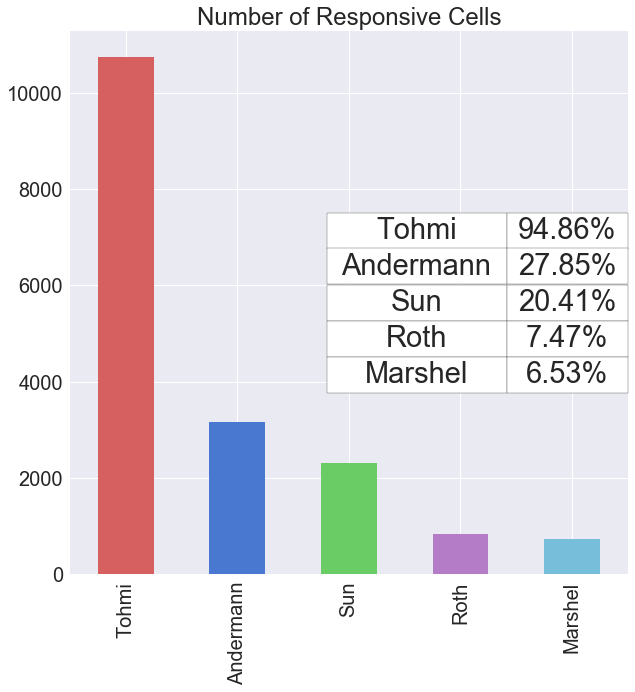

In [347]:

fig1, ax= plt.subplots(1,1, figsize = (10,10))
df = pd.DataFrame(index = [0], columns = criteria)
total_cells = np.float(rel_vs_resp_all.shape[0])
for crit in criteria:
    df[crit] = rel_vs_resp_all[rel_vs_resp_all[crit]==True].shape[0]


df.T.plot(kind = 'bar', colors = colors, legend = False, ax= ax)
ax.set_title('Number of Responsive Cells')

ax2 = fig1.add_subplot(144, frame_on=False) 
#ax2.set_title('Percent responsive cells', loc = 'left', fontsize = 34)
cellText = np.round(df.T.values/np.float16(rel_vs_resp_all.shape[0])*100, 2) 
cellText = [str(text[0]) + "%" for text in cellText]
cellText = [[text] for text in cellText]
ax2.xaxis.set_visible(False) 
ax2.yaxis.set_visible(False)
the_table = plt.table(cellText = cellText , rowLabels=df.columns,      
    cellLoc = 'center', rowLoc = 'center', loc = 'center')

the_table.set_fontsize(34)
the_table.scale(1, 3)


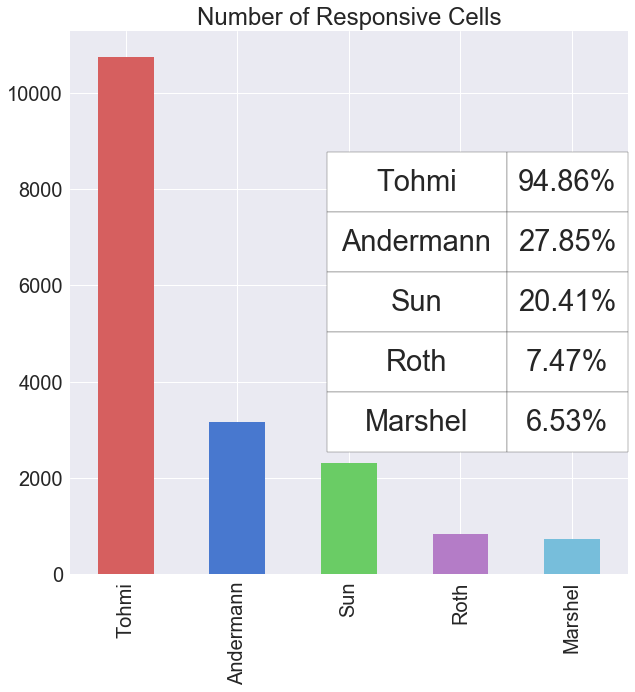

In [342]:
fig1

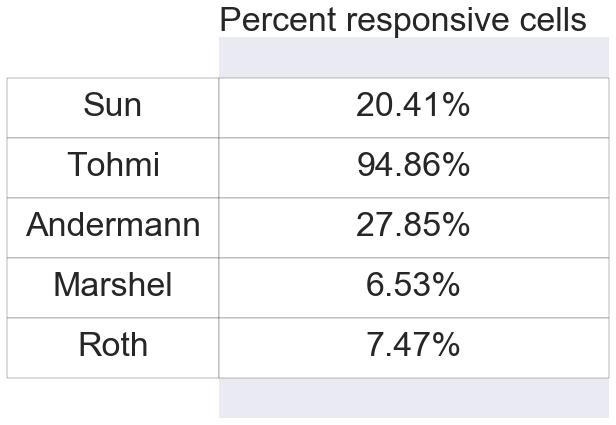

In [320]:
fig2

In [160]:
colors = {}
colors['Rbp4-Cre_KL100'] = '#5cad53'
colors['Cux2-CreERT2'] = '#a92e66'
colors['Rorb-IRES2-Cre'] = '#7841be'
colors['Scnn1a-Tg3-Cre'] = '#4f63c2'
colors['Nr5a1-Cre'] = '#5bb0b0'
colors['Emx1-IRES-Cre'] = '#9f9f9f'
areas = ['VISp','VISl','VISal','VISpm']
depths = [100,200,300]
cres = ['Rbp4-Cre_KL100', 'Cux2-CreERT2', 'Rorb-IRES2-Cre','Scnn1a-Tg3-Cre', 'Emx1-IRES-Cre', 'Nr5a1-Cre']
markers = {}
markers[100] = 's--'
markers[200] = 'o--'
markers[300] = 'v--'
sns.set(font_scale=2) 

In [338]:
# plot number of cells for each 
colors = ['r', 'b', 'g','m', 'c']
criteria = [ 'Tohmi', 'Andermann', 'Sun','Roth','Marshel']
features =  ['cell_specimen_id',
              'area',
              'reliability',
              'reliability_marshel',
              'reliability_corr',
              'DSI',
              'OSI',
              'TF',
              'pref_ori',
              'peak dF/F']
def plot_feature(rel_vs_resp_all, feature, criteria): 
    df = pd.DataFrame(index = [0], columns = criteria)
    for crit in criteria: 
        df[crit] = rel_vs_resp_all[rel_vs_resp_all[crit]==True][feature].mean()
    df.T.plot(kind = 'bar', colors = colors, legend = False)
    plt.title(feature)

    

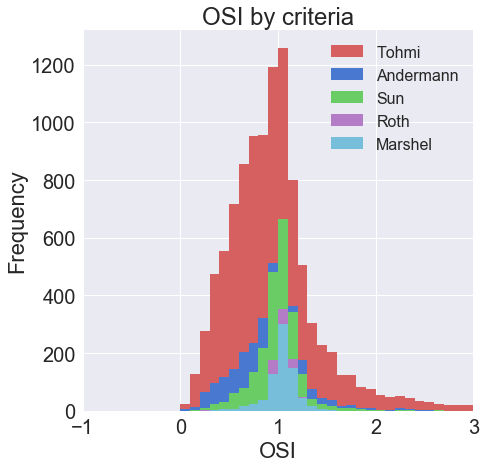

In [371]:
fig3,axis =plt.subplots(1,1, figsize = (7,7))

#for ii, axis in enumerate(ax.reshape(-1)[:5]):
for ii, crit in enumerate(criteria):
    rel_vs_resp_all[rel_vs_resp_all[criteria[ii]]==True]['OSI'].plot(kind = 'hist', ax = axis,color = colors[ii],bins = np.arange(0,10,0.1))
    axis.set_title(criteria[ii])
    axis.set_xlabel('OSI')
    axis.set_xlim(-1,3)
    
plt.title('OSI by criteria')
plt.legend(criteria, fontsize = 16)

In [372]:
fig3.savefig('OSI.jpg')

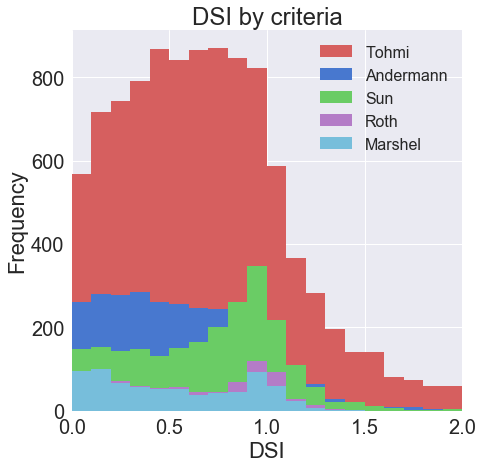

In [358]:
fig4,axis =plt.subplots(1,1, figsize = (7,7))

#for ii, axis in enumerate(ax.reshape(-1)[:5]):
for ii, crit in enumerate(criteria):
    rel_vs_resp_all[rel_vs_resp_all[criteria[ii]]==True]['DSI'].plot(kind = 'hist', color = colors[ii],ax = axis, bins = np.arange(0,10,0.1))
    axis.set_title(criteria[ii])
    axis.set_xlabel('DSI')
    axis.set_xlim(0,2)
    
plt.title('DSI by criteria')
plt.legend(criteria, fontsize = 16)

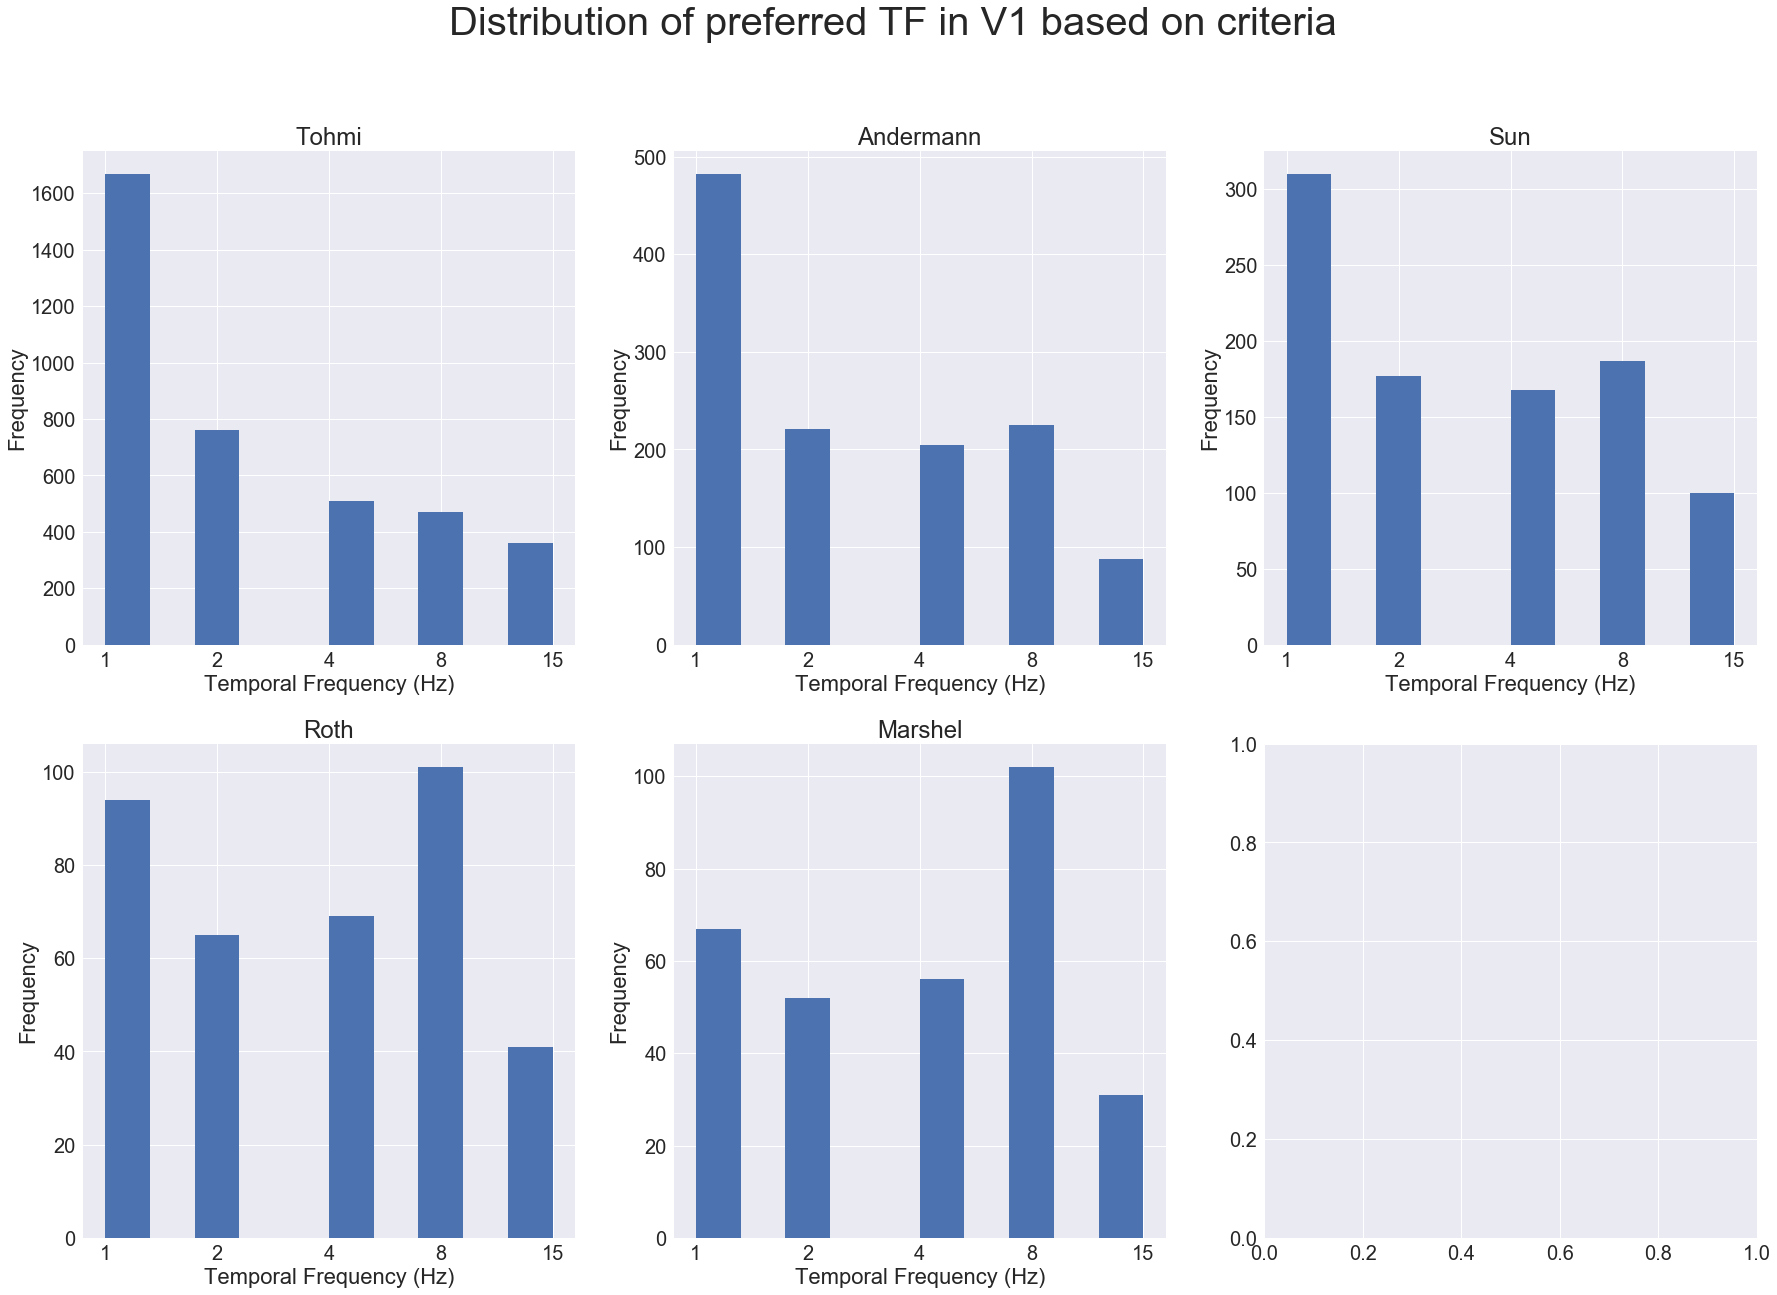

In [373]:
fig5,ax =plt.subplots(2,3, figsize = (30,20))
plt.suptitle('Distribution of preferred TF in V1 based on criteria', fontsize = 40)
for ii, axis in enumerate(ax.reshape(-1)[:5]):
    rel_vs_resp_all[(rel_vs_resp_all[criteria[ii]]==True) & (rel_vs_resp_all['area']=="VISp")]['TF'].plot(kind = 'hist', ax = axis)
    labels = ['0','1','2','4','8','15']
    loc = np.arange(len(labels))
    axis.set_xticklabels(labels)
    axis.set_title(criteria[ii])
    axis.set_xlabel('Temporal Frequency (Hz)')

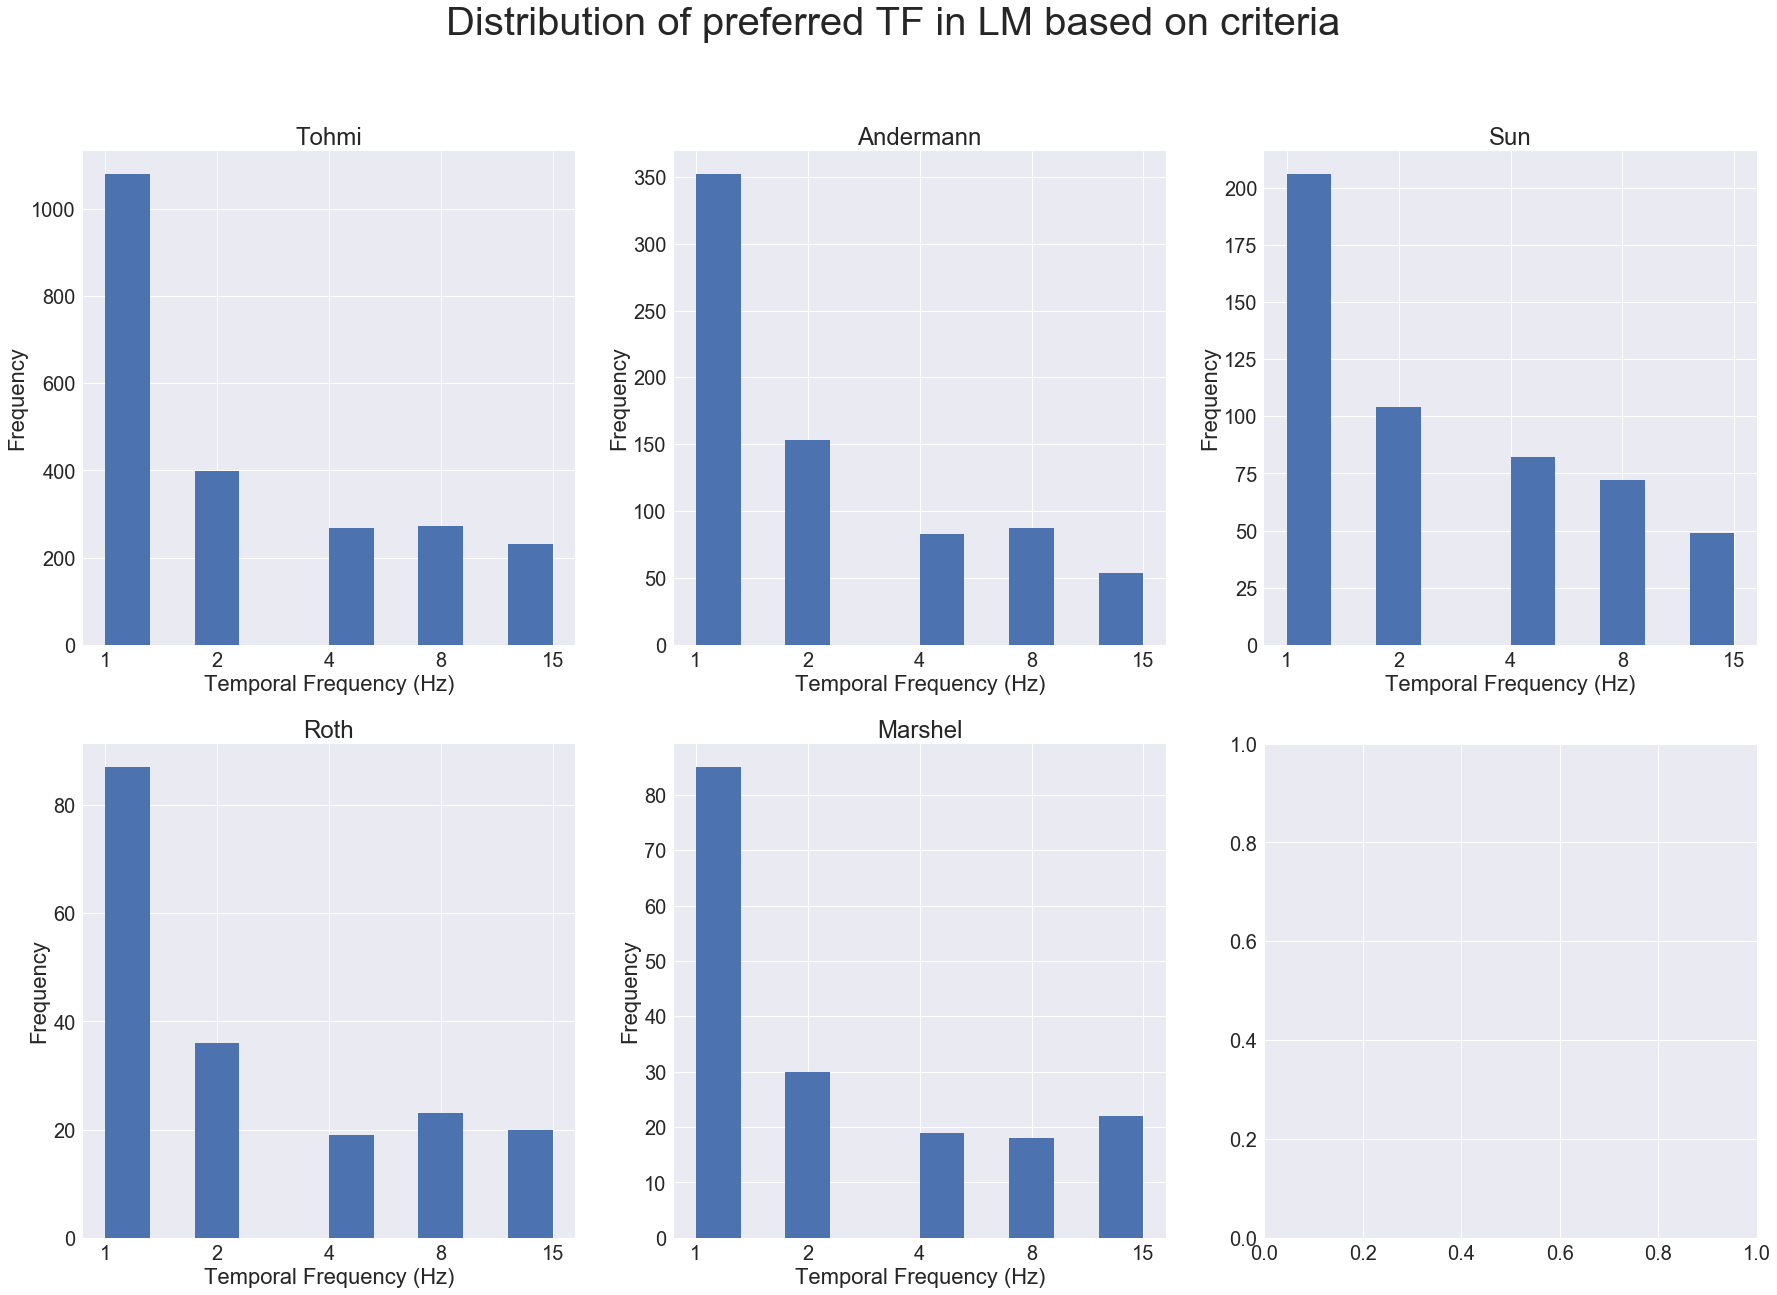

In [291]:
fig5,ax =plt.subplots(2,3, figsize = (30,20))
plt.suptitle('Distribution of preferred TF in LM based on criteria', fontsize = 40)
for ii, axis in enumerate(ax.reshape(-1)[:5]):
    rel_vs_resp_all[(rel_vs_resp_all[criteria[ii]]==True) & (rel_vs_resp_all['area']=="VISl")]['TF'].plot(kind = 'hist', ax = axis)
    labels = ['0','1','2','4','8','15']
    loc = np.arange(len(labels))
    axis.set_xticklabels(labels)
    axis.set_title(criteria[ii])
    axis.set_xlabel('Temporal Frequency (Hz)')

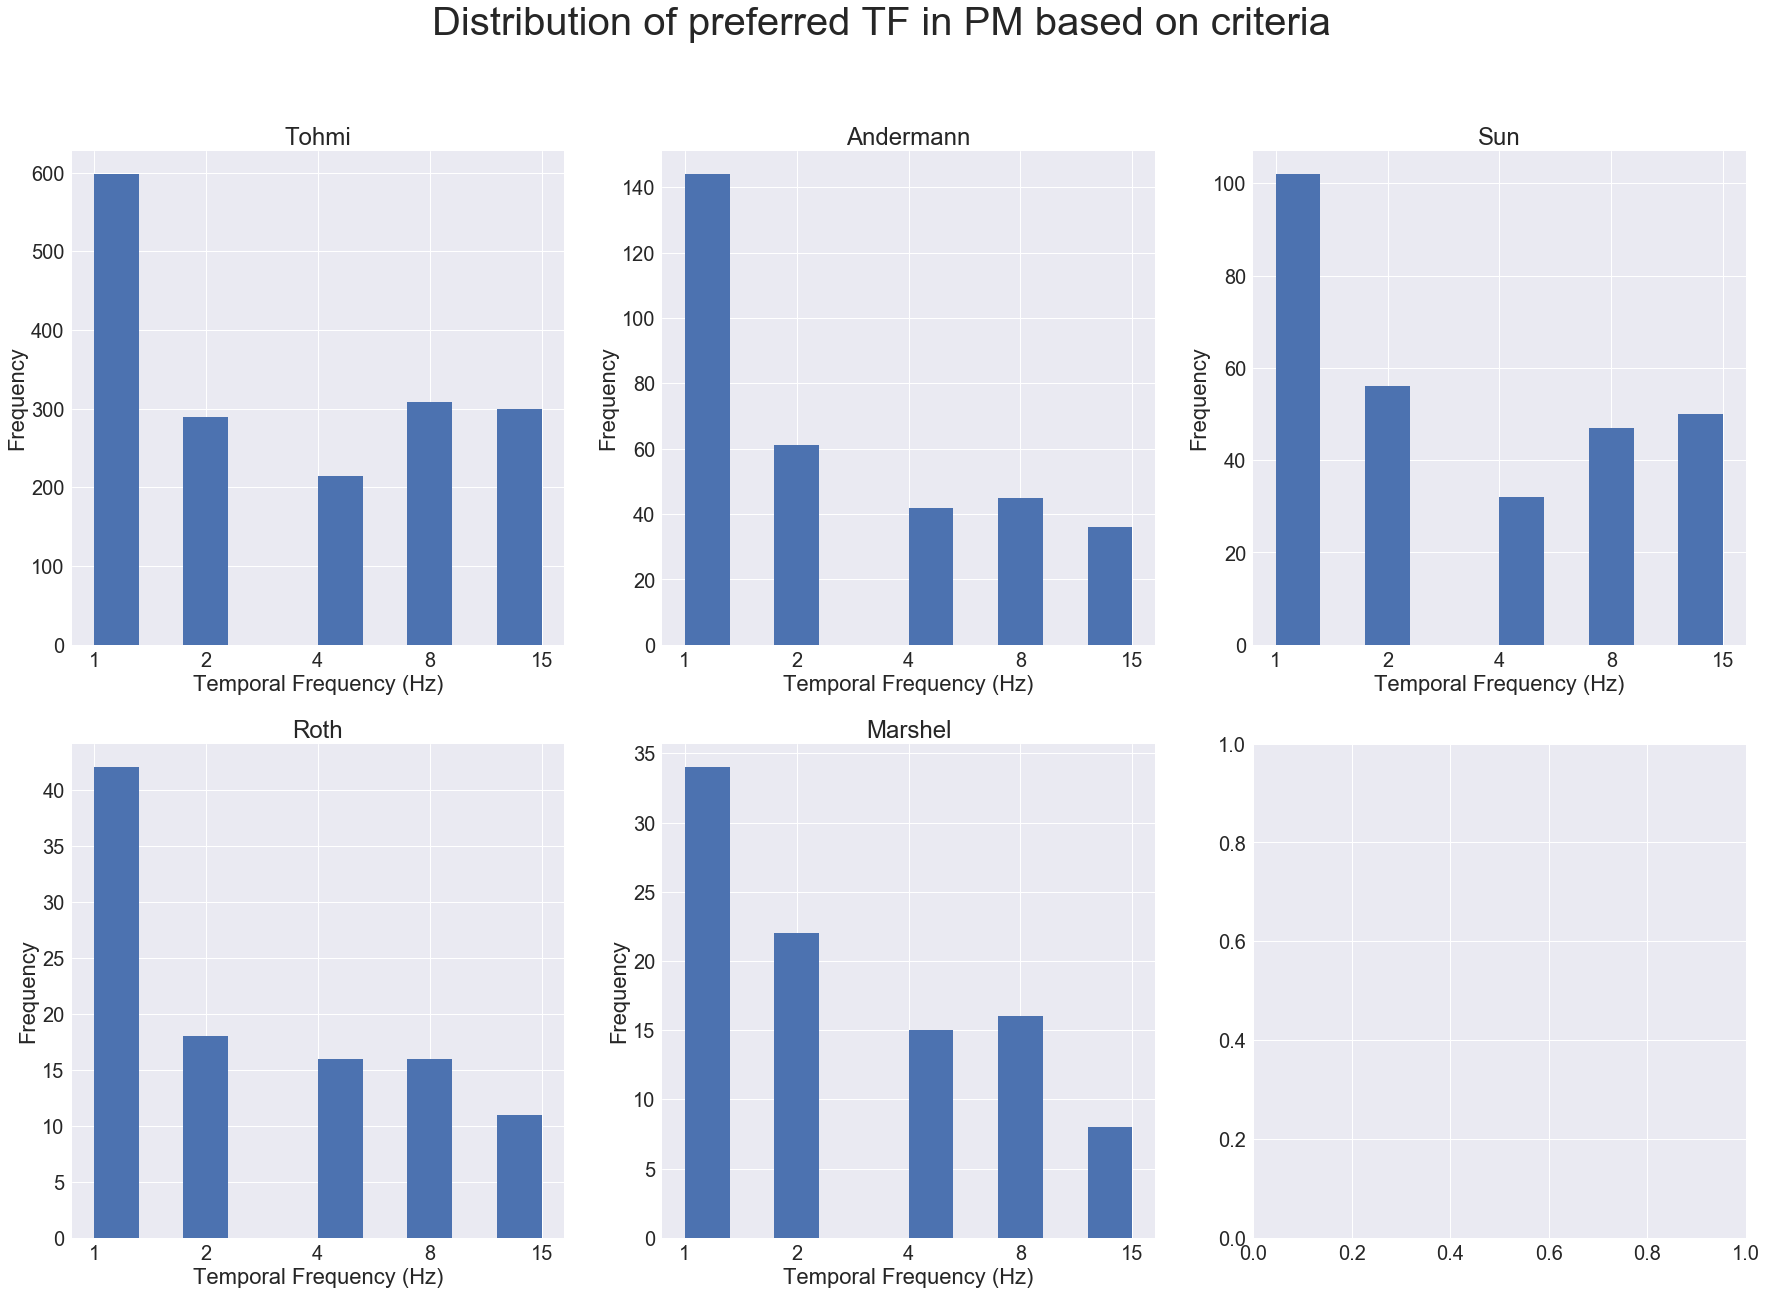

In [292]:
fig7,ax =plt.subplots(2,3, figsize = (30,20))
plt.suptitle('Distribution of preferred TF in PM based on criteria', fontsize = 40)

for ii, axis in enumerate(ax.reshape(-1)[:5]):
    rel_vs_resp_all[(rel_vs_resp_all[criteria[ii]]==True) & (rel_vs_resp_all['area']=="VISpm")]['TF'].plot(kind = 'hist', ax = axis)
    labels = ['0','1','2','4','8','15']
    loc = np.arange(len(labels))
    axis.set_xticklabels(labels)
    axis.set_title(criteria[ii])
    axis.set_xlabel('Temporal Frequency (Hz)')

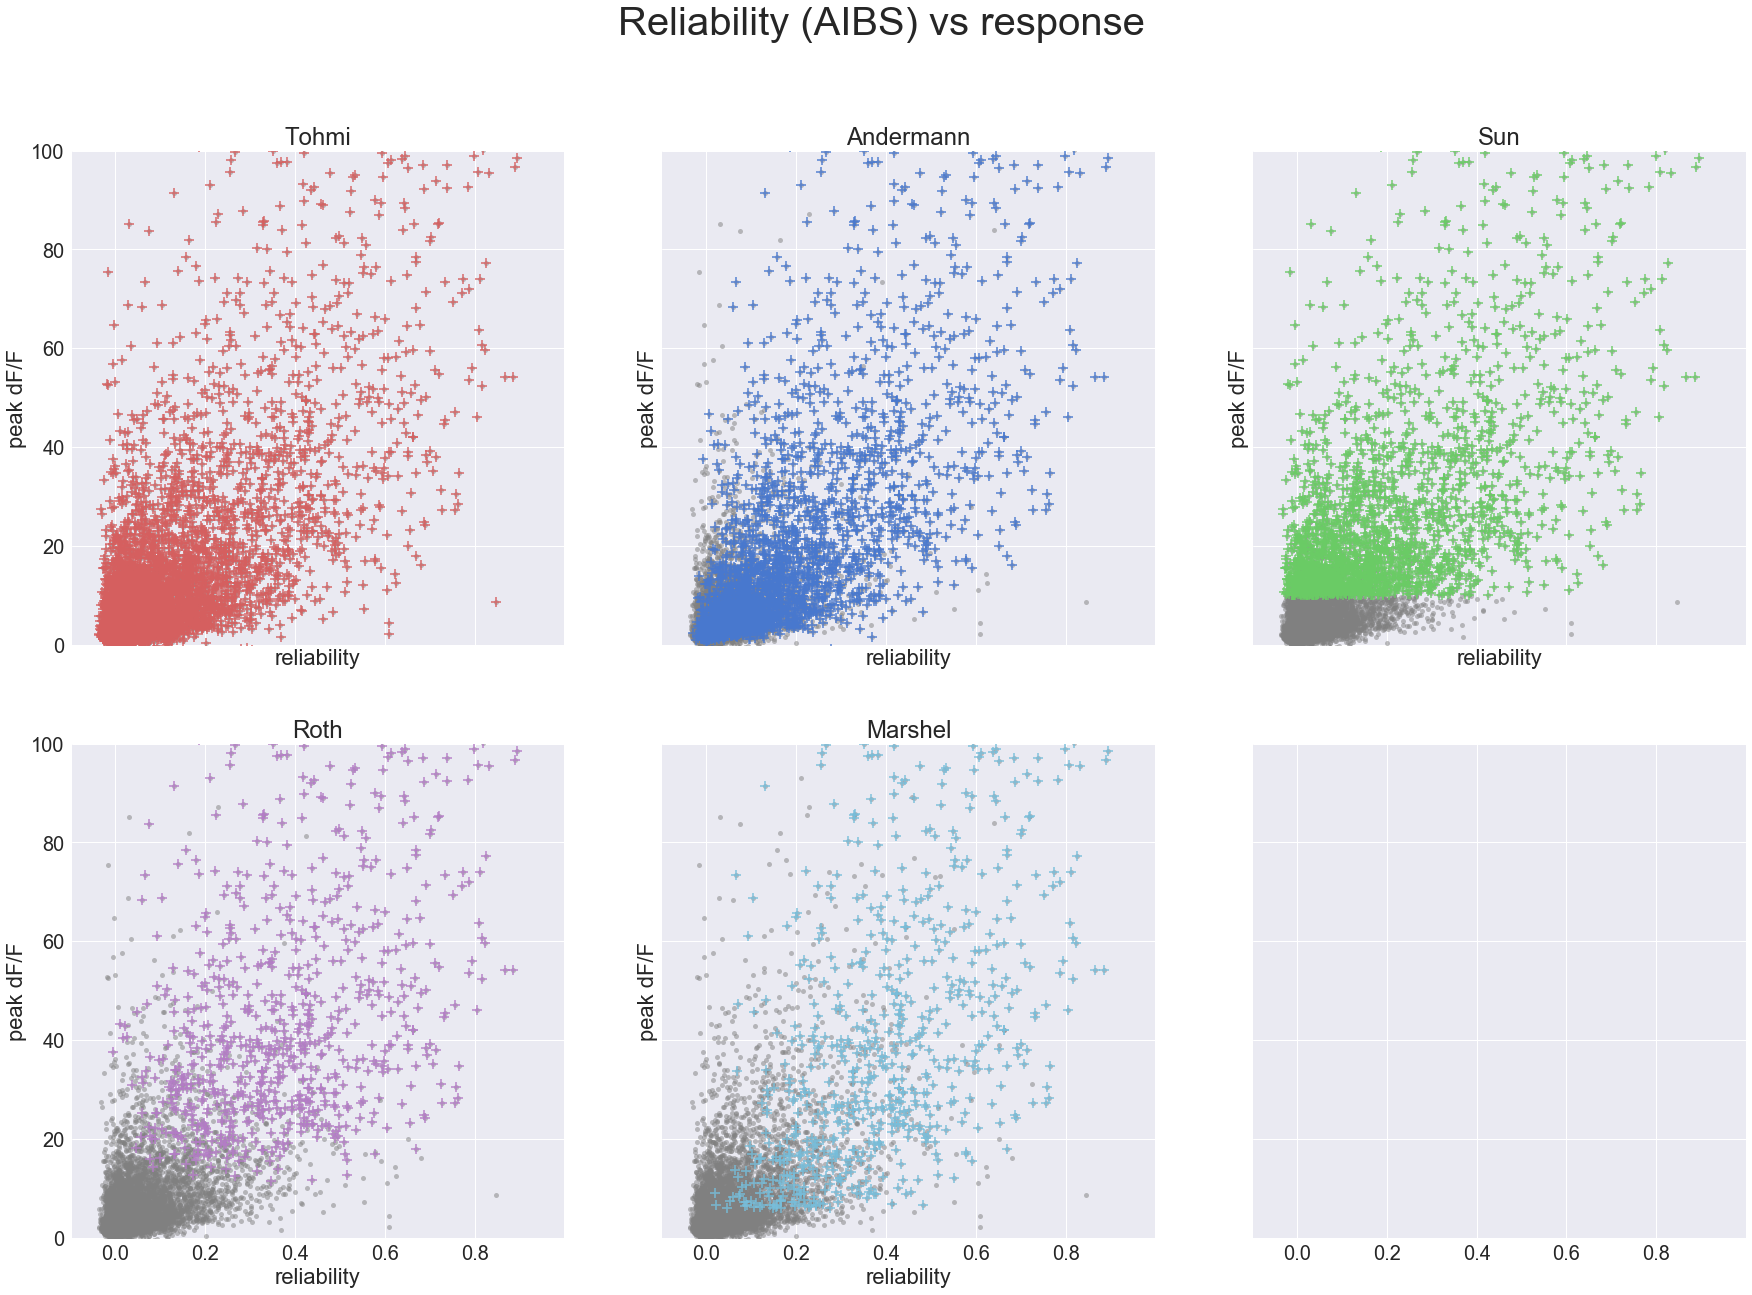

In [294]:
fig8, axs = plt.subplots(2,3, figsize = (30,20 ), sharex = True, sharey = True)
plt.ylim(0, 100)
plt.suptitle('Reliability (AIBS) vs response', fontsize = 40)
#plt.xlim(0, 0.2)

for ii, ax in enumerate(axs.reshape(-1)[:5]):
    sns.regplot(x = 'reliability', 
        y = 'peak dF/F', 
        fit_reg = False,
        data = rel_vs_resp_all, 
        color = [0.5,0.5,0.5], 
        marker = '.', 
        scatter_kws = {"s": 100, "alpha": 0.5}, 
        ax = ax)
    sns.regplot(x = 'reliability', 
            y = 'peak dF/F', 
            fit_reg = False,
            data = rel_vs_resp_all[rel_vs_resp_all[criteria[ii]]==True], 
            color = colors[ii], 
            marker = '+', 
            scatter_kws = {"s": 100}, 
            ax = ax).set_title(criteria[ii])




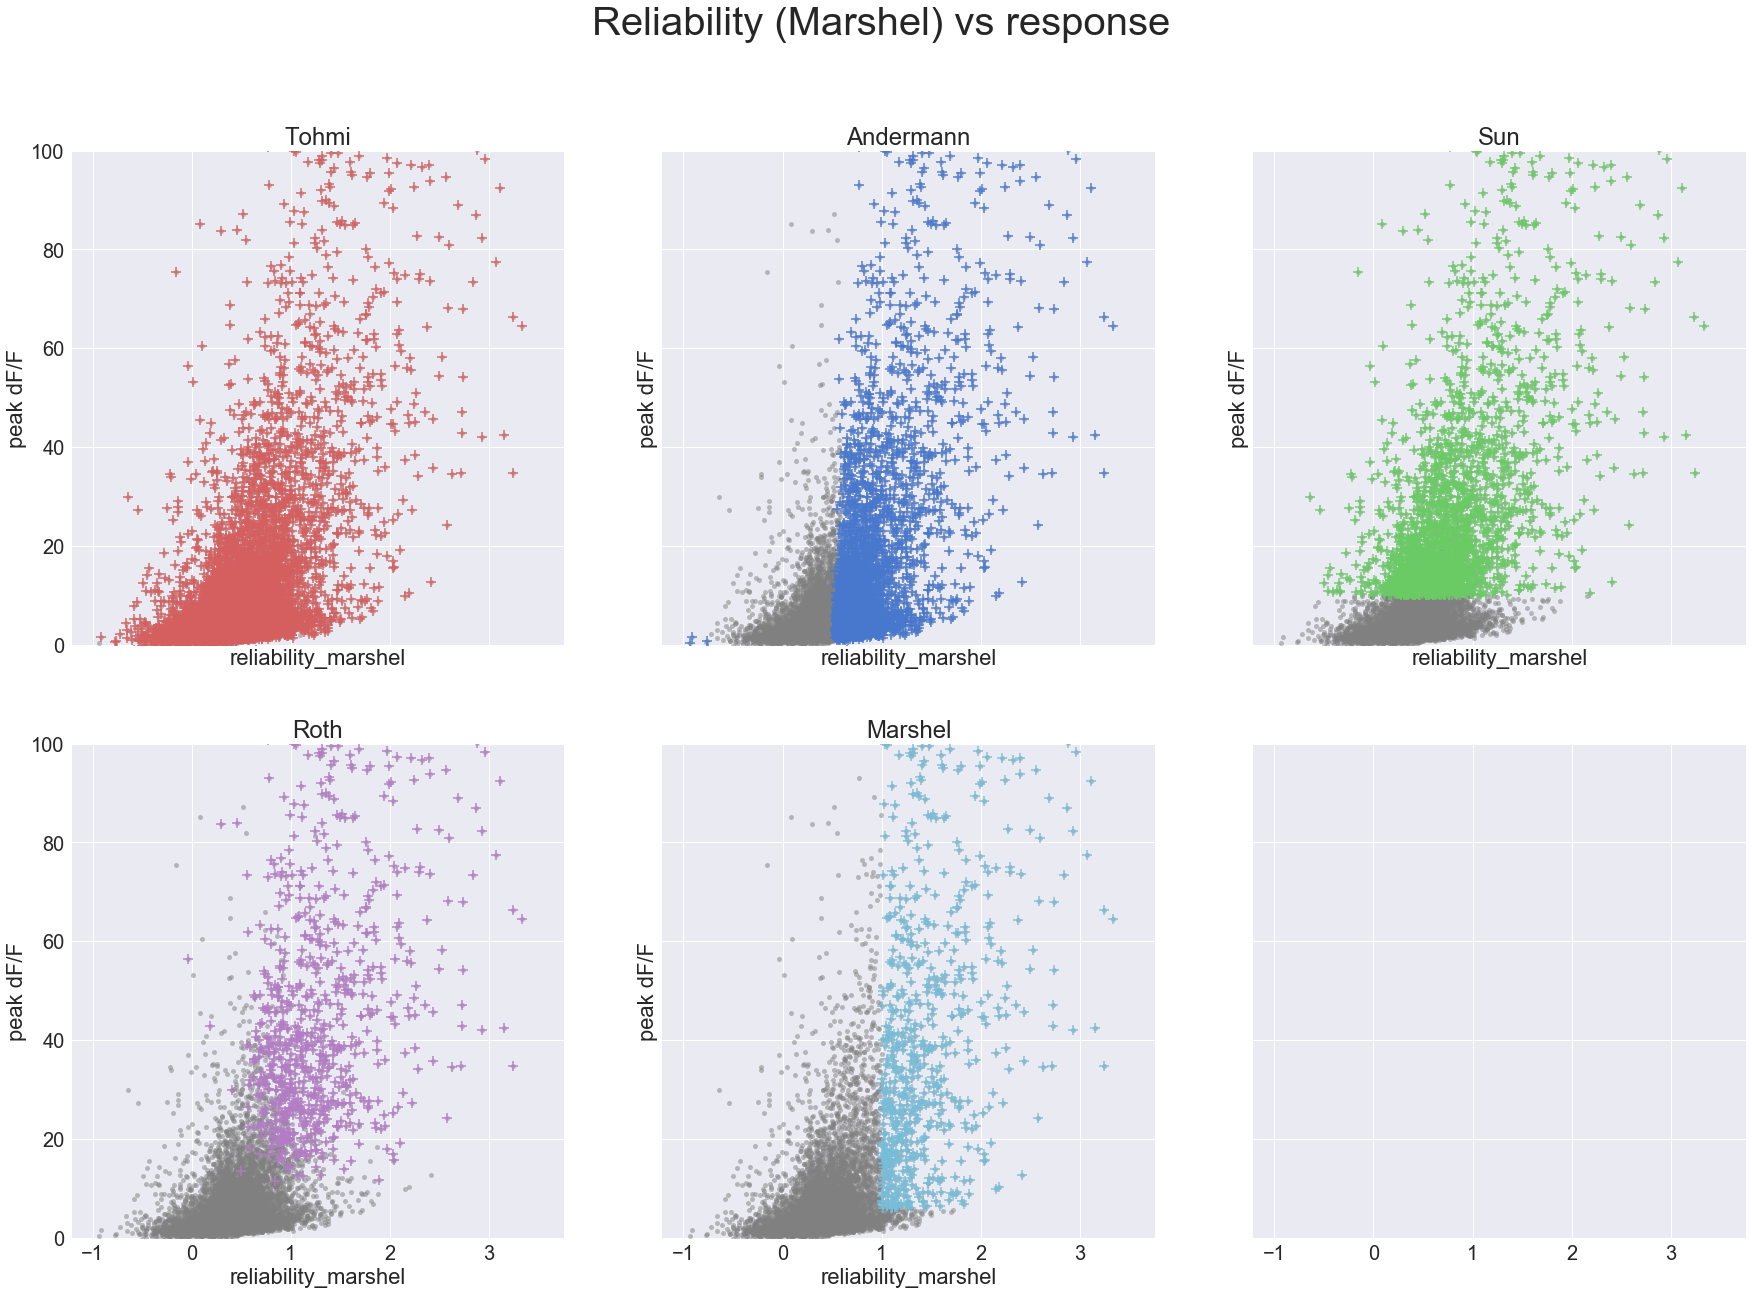

In [295]:

fig9, axs = plt.subplots(2,3, figsize = (30,20 ), sharex = True, sharey = True)
plt.ylim(0, 100)
#plt.xlim(0, 0.2)
plt.suptitle('Reliability (Marshel) vs response', fontsize = 40)

for ii, ax in enumerate(axs.reshape(-1)[:5]):
    sns.regplot(x = 'reliability_marshel', 
        y = 'peak dF/F', 
        fit_reg = False,
        data = rel_vs_resp_all, 
        color = [0.5,0.5,0.5], 
        marker = '.', 
        scatter_kws = {"s": 100, "alpha": 0.5}, 
        ax = ax)
    sns.regplot(x = 'reliability_marshel', 
        y = 'peak dF/F', 
        fit_reg = False,
        data = rel_vs_resp_all[rel_vs_resp_all[criteria[ii]]==True], 
        color = colors[ii], 
        marker = '+', 
        scatter_kws = {"s": 100}, 
        ax = ax).set_title(criteria[ii])




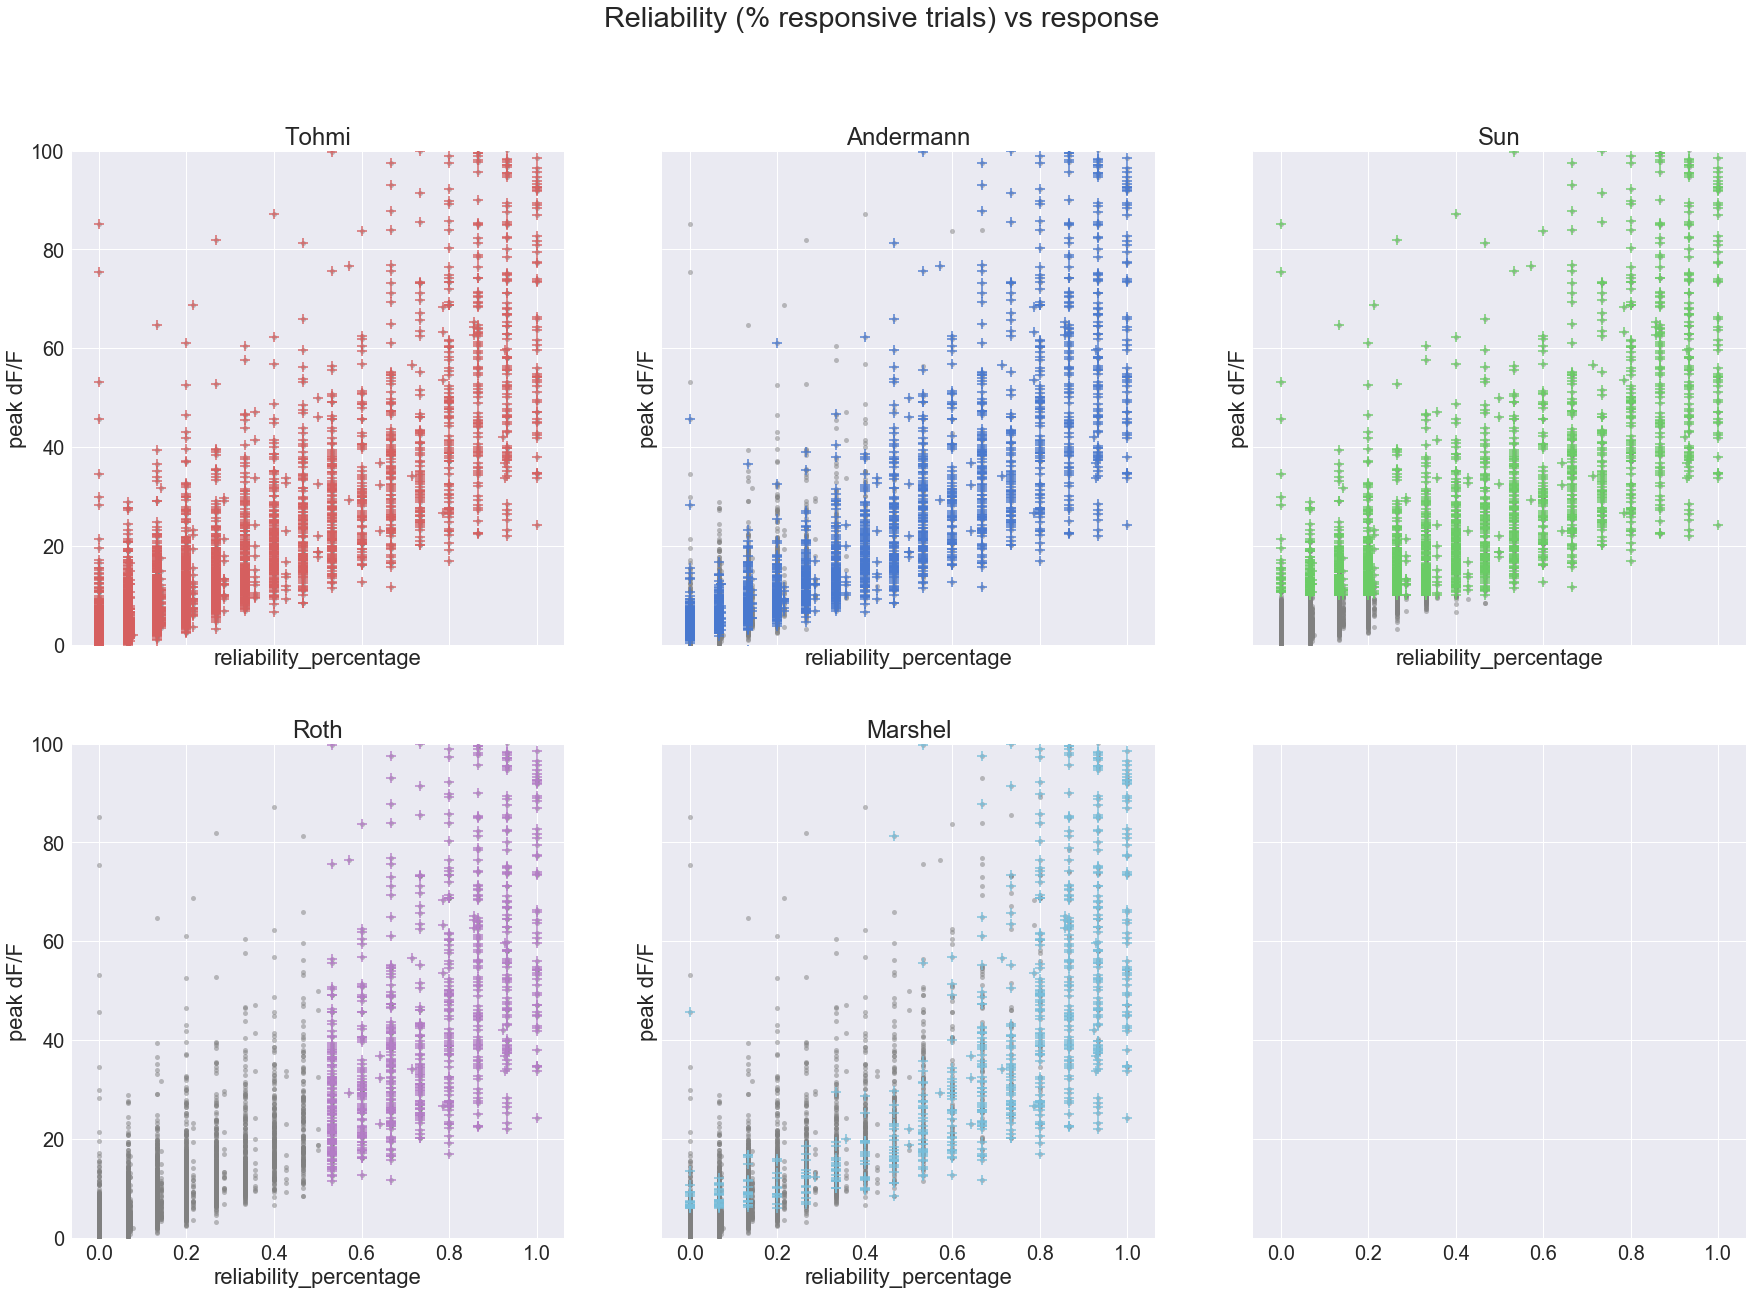

In [298]:
fig10, axs = plt.subplots(2,3, figsize = (30,20 ), sharex = True, sharey = True)
plt.ylim(0, 100)
#plt.xlim(0, 0.2)
plt.suptitle('Reliability (% responsive trials) vs response')
for ii, ax in enumerate(axs.reshape(-1)[:5]):
    sns.regplot(x = 'reliability_percentage', 
        y = 'peak dF/F', 
        fit_reg = False,
        data = rel_vs_resp_all, 
        color = [0.5,0.5,0.5], 
        marker = '.', 
        scatter_kws = {"s": 100, "alpha": 0.5}, 
        ax = ax)
    sns.regplot(x = 'reliability_percentage', 
            y = 'peak dF/F', 
            fit_reg = False,
            data = rel_vs_resp_all[rel_vs_resp_all[criteria[ii]]==True], 
            color = colors[ii], 
            marker = '+', 
            scatter_kws = {"s": 100}, 
            ax = ax).set_title(criteria[ii])




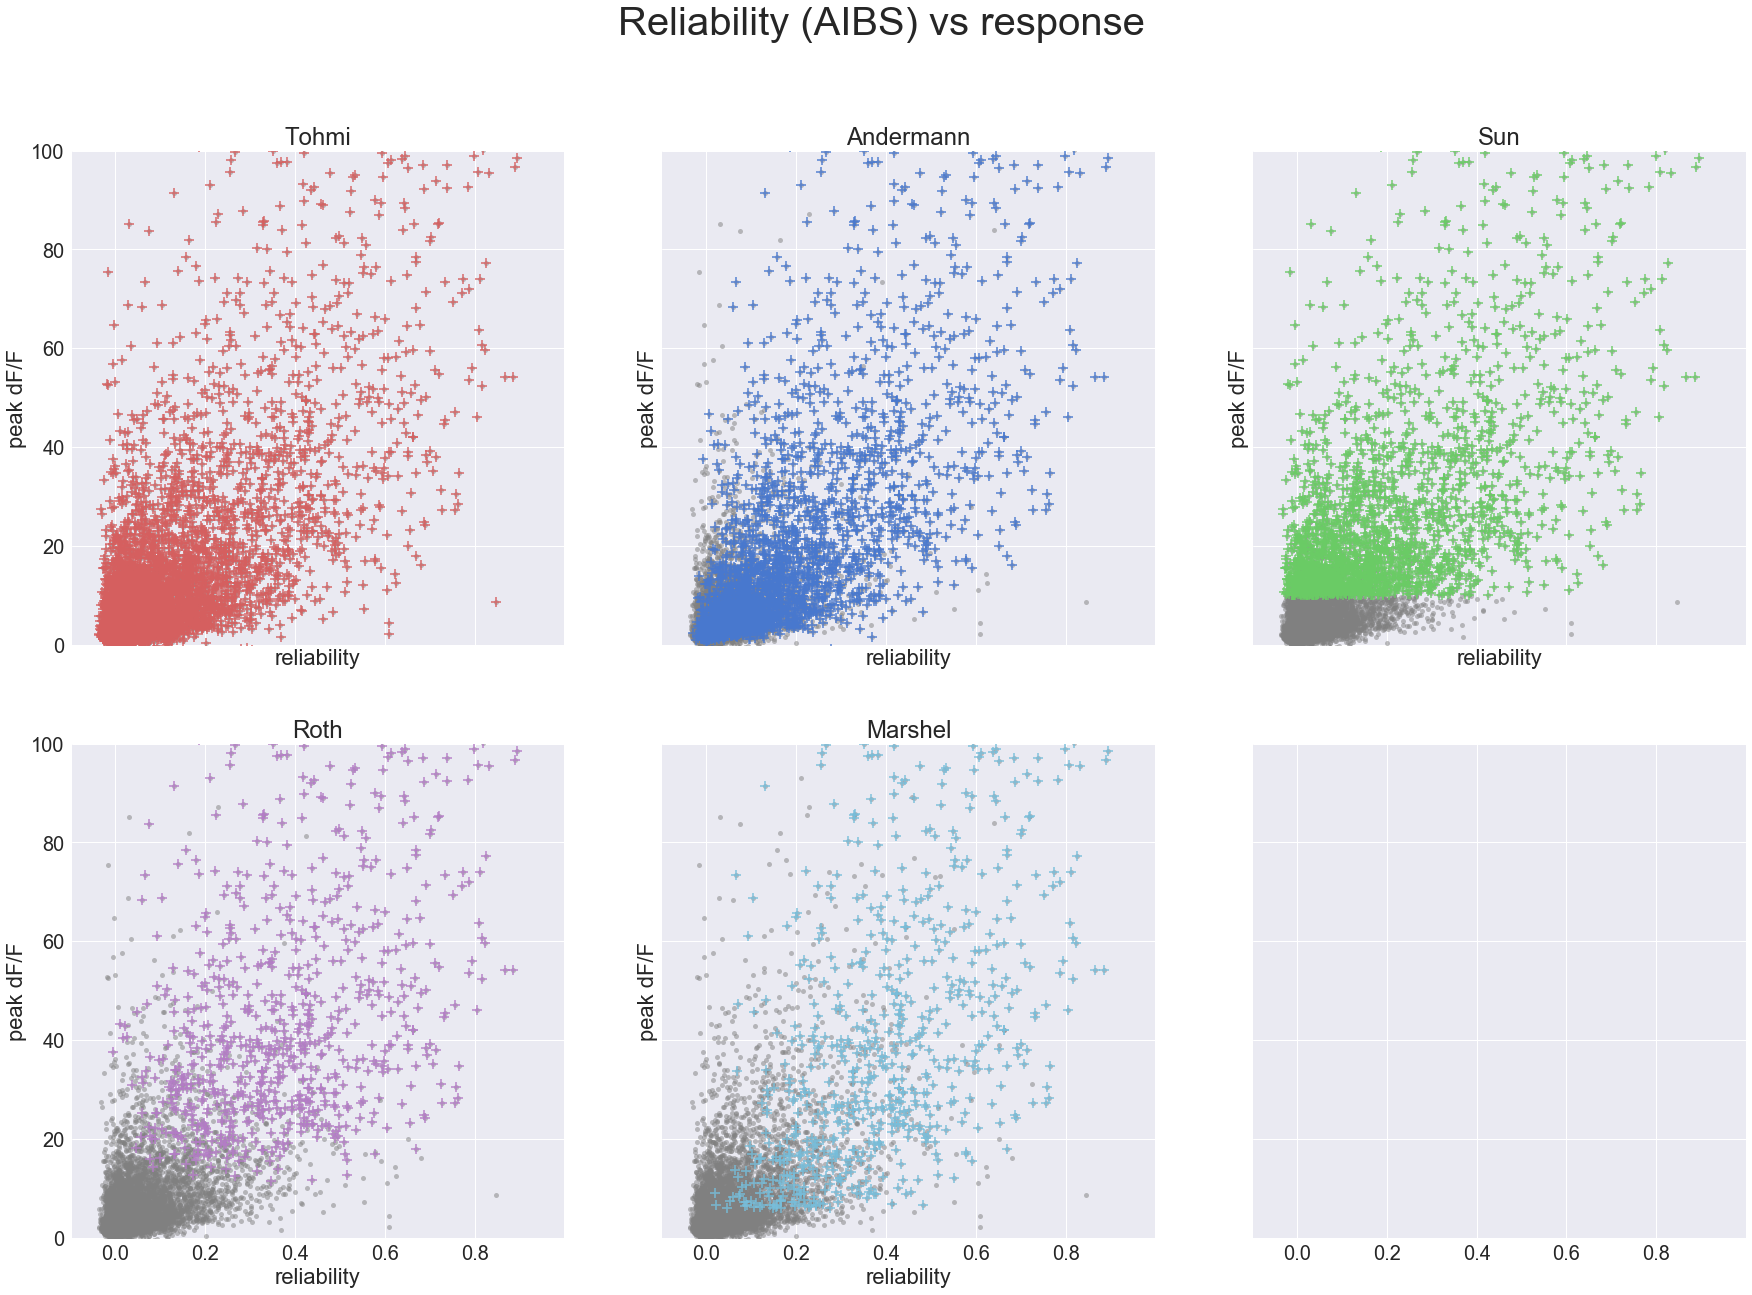

In [361]:
fig9color = colors[ii]

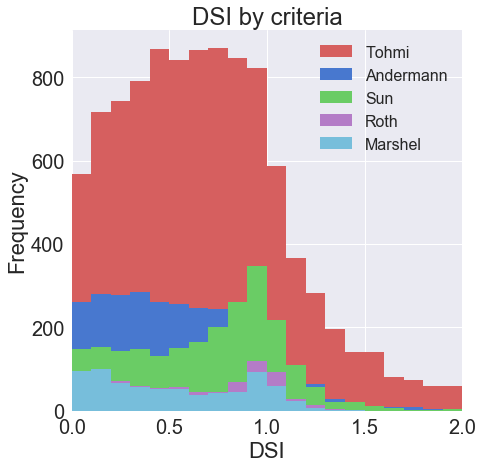

In [366]:
fig3

In [367]:
figs = [fig1, fig3, fig4,fig5, fig7, fig8, fig9, fig10]

In [363]:
import datetime
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

# Create the PdfPages object to which we will save the pages:
# The with statement makes sure that the PdfPages object is closed properly at
# the end of the block, even if an Exception occurs.
with PdfPages('response_vs_reliability_plots.pdf') as pdf:
    for fig in figs:
        pdf.savefig(fig)
        

In [ ]:
for cell in range(dg.numbercells):
#for cell in range(1):
    pref_stim_resp = dg.sweep_response[(stim_table['temporal_frequency']== pref_tf) & (stim_table['orientation']== pref_ori)][str(cell)]
    
    covariance_matrix = np.cov(pref_stim_resp)
    cov_matrix = np.corrcoef(np.array(pref_stim_resp.tolist()))
    rel_vs_resp['reliability_corr'].iloc[cell] = np.mean(cov_matrix[np.triu_indices(cov_matrix.shape[0], k = 1)])

In [ ]:
cov_matrix = np.corrcoef(np.array(pref_stim_resp.tolist()))
cov_matrix[np.triu_indices(cov_matrix.shape[0], k = 1)]